In [59]:
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

## Posterior of correlation coefficient

Given a set of $n$ point from a bivariate Gaussian and estimate $\hat r$ of the Pearson correlation coefficient, what is the posterior of the correlation coefficient $\rho$?

Set up estimator and its PDF:

In [65]:
def pearson_r(data, axis=0):
    """Compute the Pearson correlation coefficient."""
    x=data[:,0]
    y=data[:,1]
    x_ = x - np.mean(x, axis=axis, keepdims=True)
    y_ = y - np.mean(y, axis=axis, keepdims=True)
    r = np.sum(x_*y_, axis=axis) / (np.sqrt(np.sum(x_**2, axis=axis))*np.sqrt(np.sum(y_**2, axis=axis)))
    return r

def pearson_r_pdf(r, n, rho):
    """Compute the PDF of the Pearson correlation coefficient."""
    # https://mathworld.wolfram.com/CorrelationCoefficientBivariateNormalDistribution.html
    hypergeom = scipy.special.hyp2f1(0.5, 0.5, (2*n-1)/2, (rho*r+1)/2)
    Gamma = scipy.special.gamma
    return (
        (n-2)*Gamma(n-1)*(1-rho**2)**((n-1)/2)*(1-r**2)**((n-4)/2) 
        / (np.sqrt(2*np.pi)*Gamma(n-0.5)*(1-rho*r)**(n-3/2))
        * hypergeom
    )

Create data and estimate the Pearson correlation coefficient:

In [69]:
# Define the covariance matrix for our RVs
rho = 0.5
cov = np.array(
    [[1, rho],
     [rho, 1]]
)
# We use n samples to estimate the correlation coefficient from
n = 100

data = scipy.stats.multivariate_normal(cov=cov).rvs((n))

# estimate pearson_r:
r_estimate = pearson_r(data, axis=0)


Define prior, likelihood and combine to posterior:

In [70]:
def prior_rho(rho):
    # Uniform prior rho \sim U(-1, 1)
    return np.piecewise(rho, [(rho > -1) & (rho < 1)], [0.5, 0])

def likelihood_rho(r, rho):
    return pearson_r_pdf(r, n, rho)

def posterior_rho(rho, r):
    return prior_rho(rho) * likelihood_rho(r, rho)


Now calculate a posterior given our estimate of the Pearson correlation coefficient of n data points:

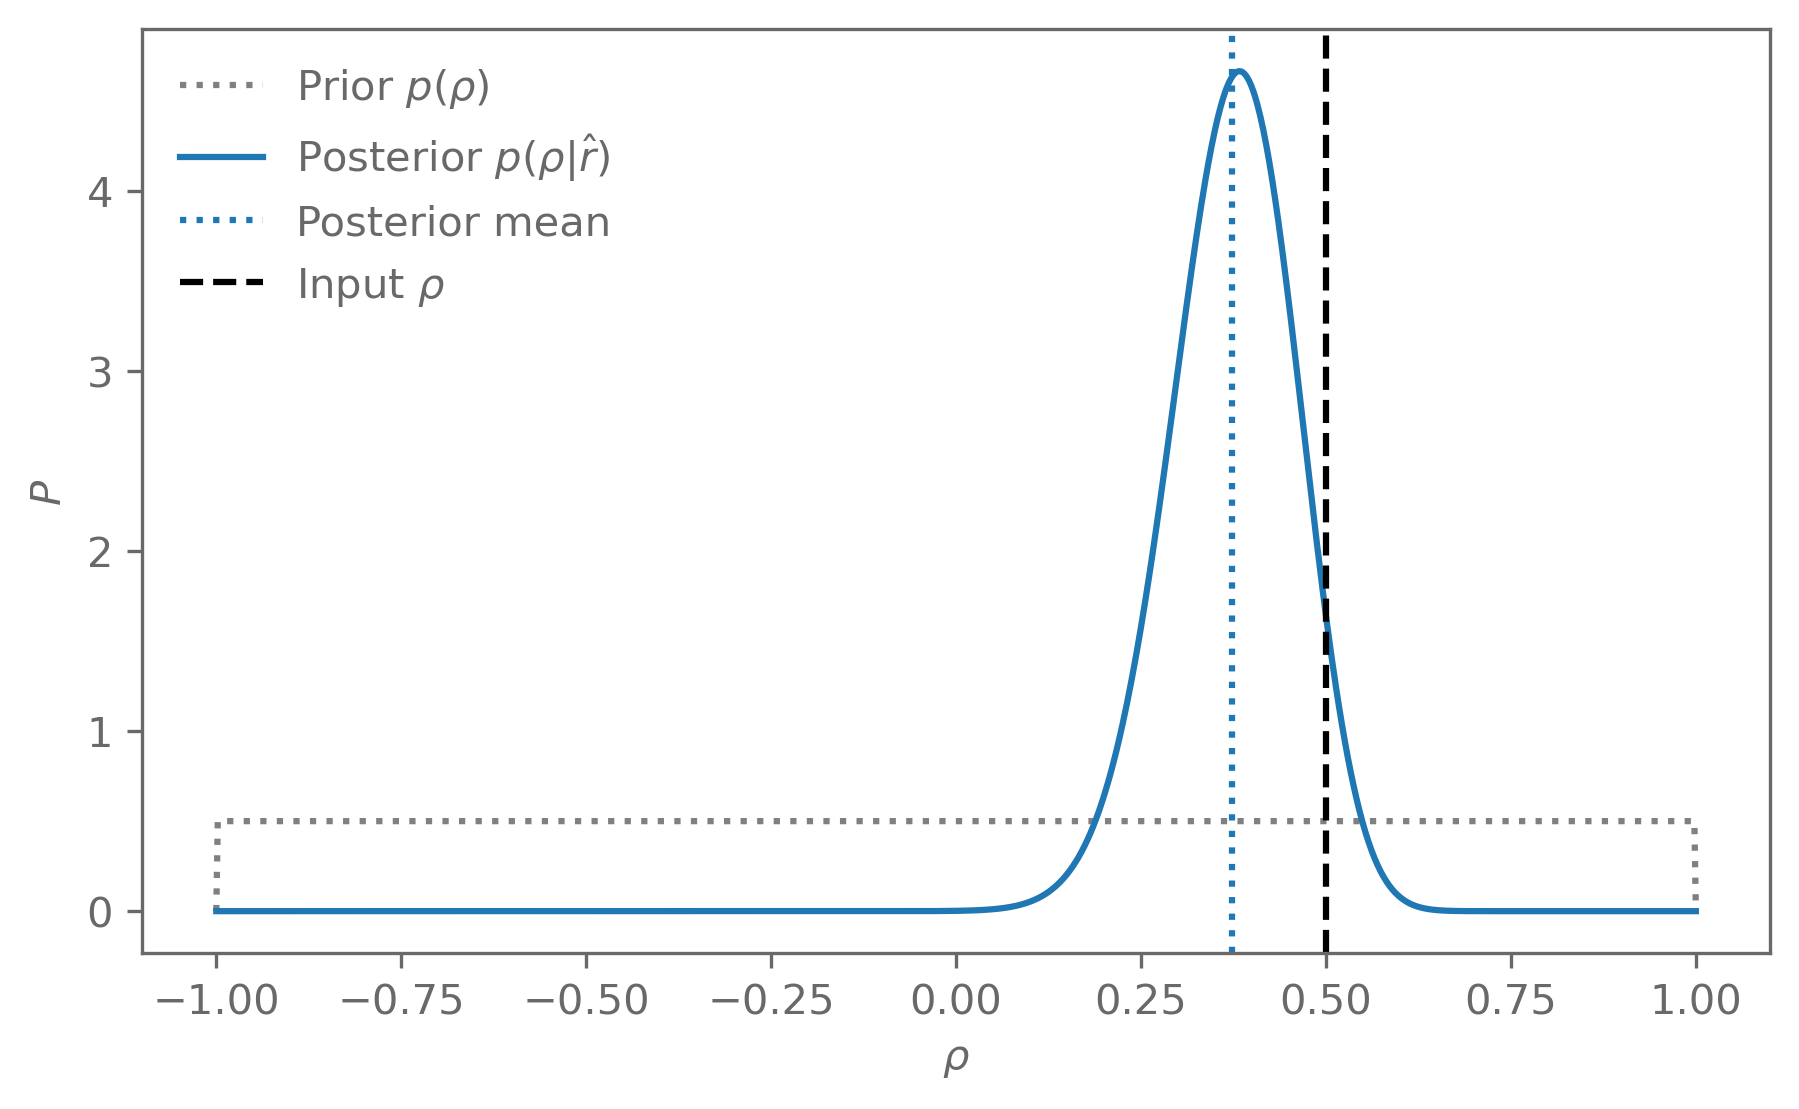

In [75]:
rho_grid = np.linspace(-1,1,1000)

norm = np.trapz(posterior_rho(rho_grid, r_estimate), x=rho_grid)
mean = np.trapz(rho_grid * posterior_rho(rho_grid, r_estimate)/norm, x=rho_grid)

plt.plot(rho_grid, prior_rho(rho_grid),c="grey", ls=":", label=r"Prior $p(\rho)$")
plt.plot(rho_grid, posterior_rho(rho_grid, r_estimate)/norm, label=r'Posterior $p(\rho \vert \hat{r} )$')
plt.axvline(mean,color='C0',linestyle='dotted', label=r'Posterior mean')
plt.axvline(rho, linestyle='dashed',color='black', label=r'Input $\rho$')
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel(r'$\rho$');

Note that this works much better if the number of data points n is increased

## Bootstrap distribution of Pearson correlation coefficient

Sample $n$ points from a bivariate Gaussian with correlation $\rho$ and estimate the Pearson correlation coefficent $\hat r$.

What is the bootstrap distribtion of $\hat r$? How does it compare to the likelihood $p(\hat r | \rho)$? How does changing the number of points $n$ affect the results?

In [72]:
def bootstrap(data, statistic, n_trial):
    n_data = data.shape[0]
    s = []
    for i in range(n_trial):
        idx = np.random.choice(n_data, size=n_data, replace=True)
        data_resampled = data[idx]
        s.append(statistic(data_resampled))
    
    return np.array(s)

In [78]:
def make_data_and_plots(n):
    s = scipy.stats.multivariate_normal(cov=cov).rvs(n)
    r_data = pearson_r(data=s)

    # Plot the data
    plt.figure()
    plt.scatter(*s.T)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title(r"$n = {}$, $\rho = {}$".format(n, rho))

    r_resample = bootstrap(
        data=s,
        statistic=pearson_r,
        n_trial=10000
    )

    # Plot the bootstrap distribution
    plt.figure()
    plt.hist(r_resample, bins=50, density=True, alpha=0.5, color="C0", label=r"Bootstrap $p(\hat r)$")
    plt.axvline(r_data, color="C0", ls="--", label=r"$\hat r$")
    plt.axvline(rho, color="C1", ls="--", label=r"$\rho_\mathrm{true}$")

    x = np.linspace(-0.5, 1.0, 100)
    plt.plot(x, pearson_r_pdf(r=x, n=n, rho=rho), color="C1", label=r"$p(r | \rho=\rho_\mathrm{true})$")
    plt.plot(x, pearson_r_pdf(r=x, n=n, rho=r_data), color="C0", label=r"$p(r | \rho=\hat r)$")

    plt.legend()
    plt.title(r"$n = {}$".format(n))

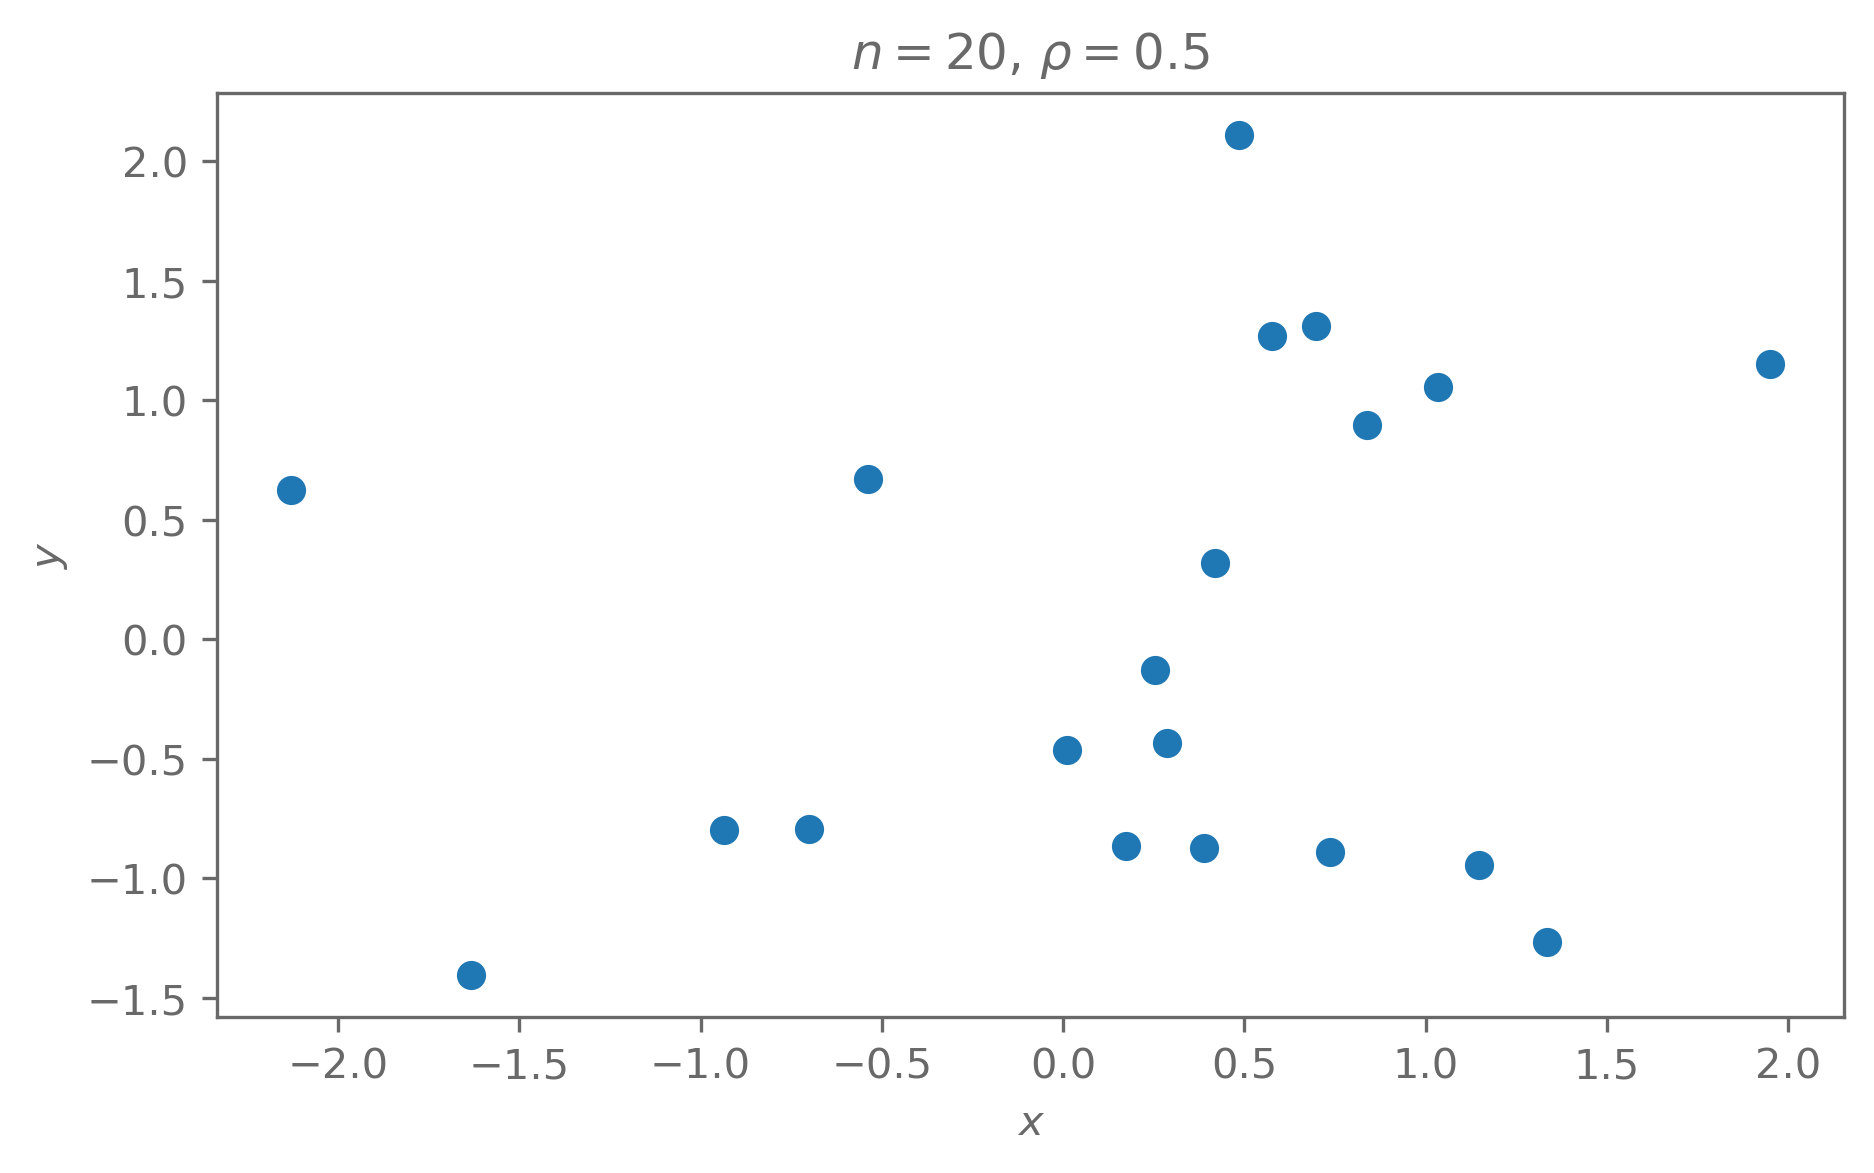

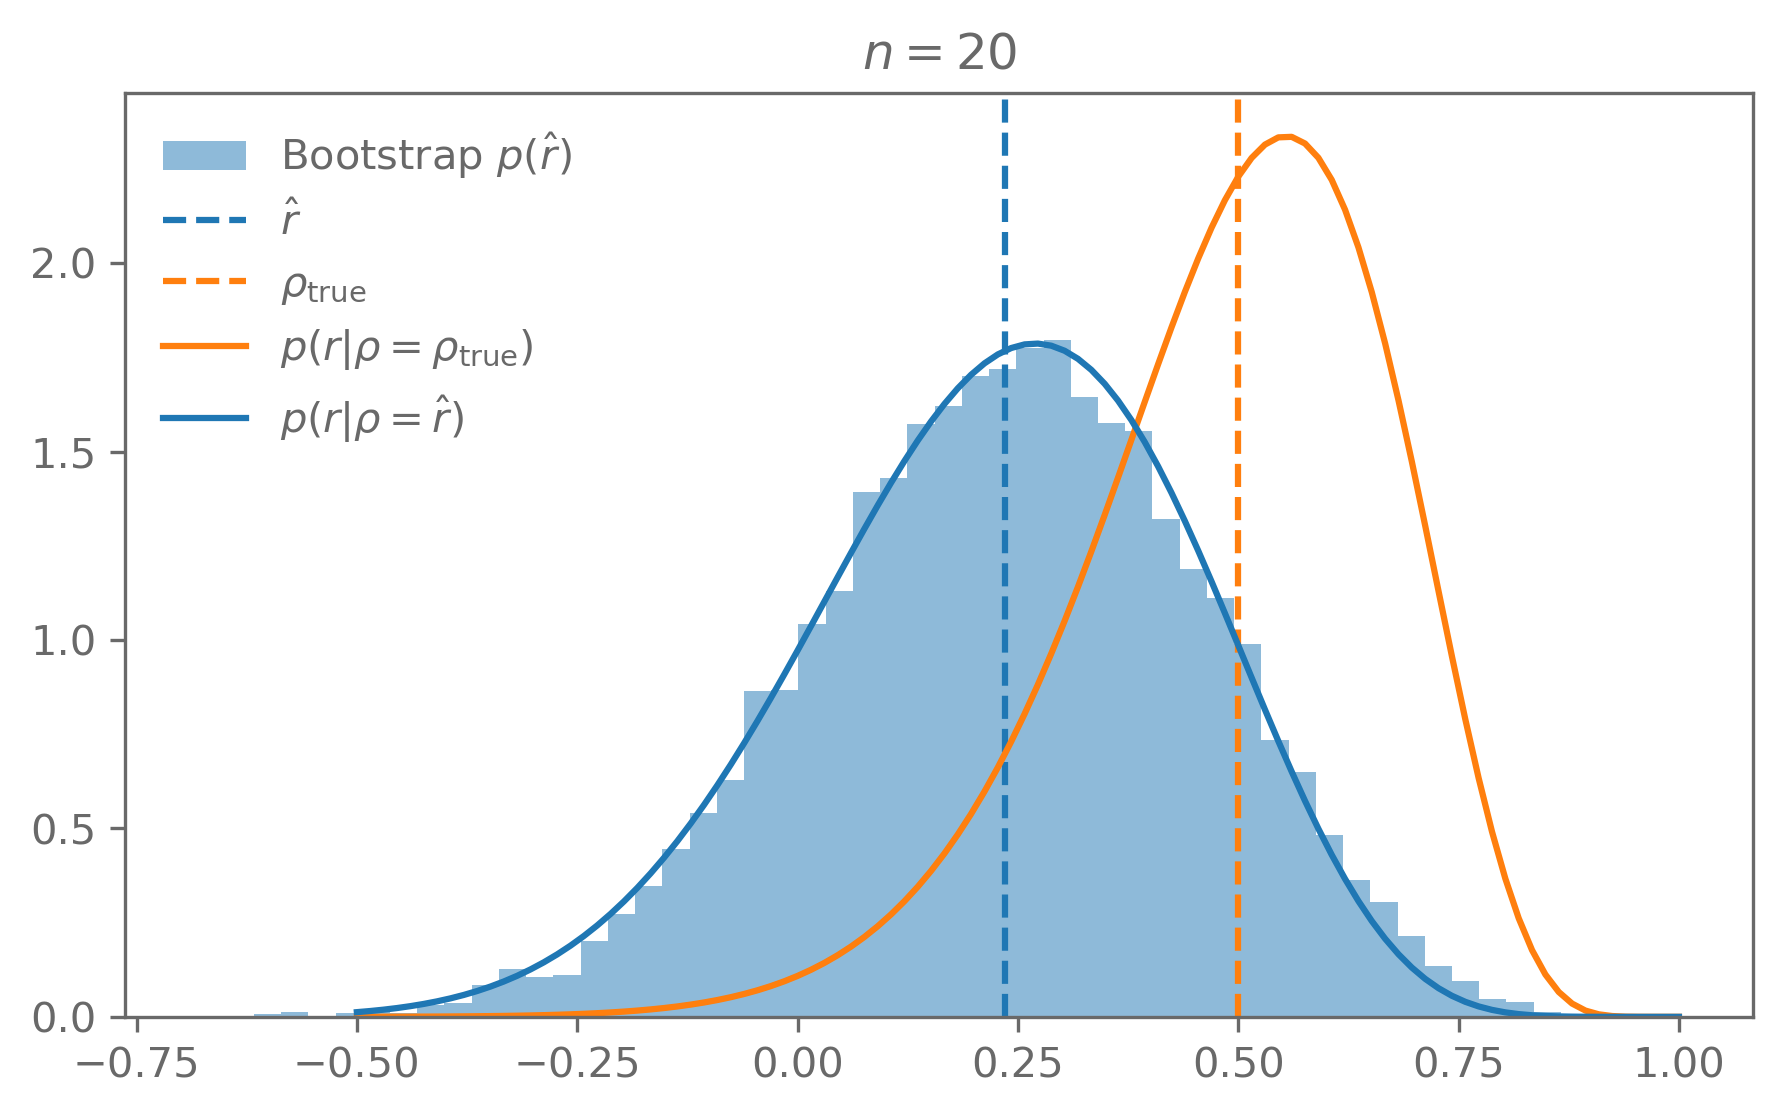

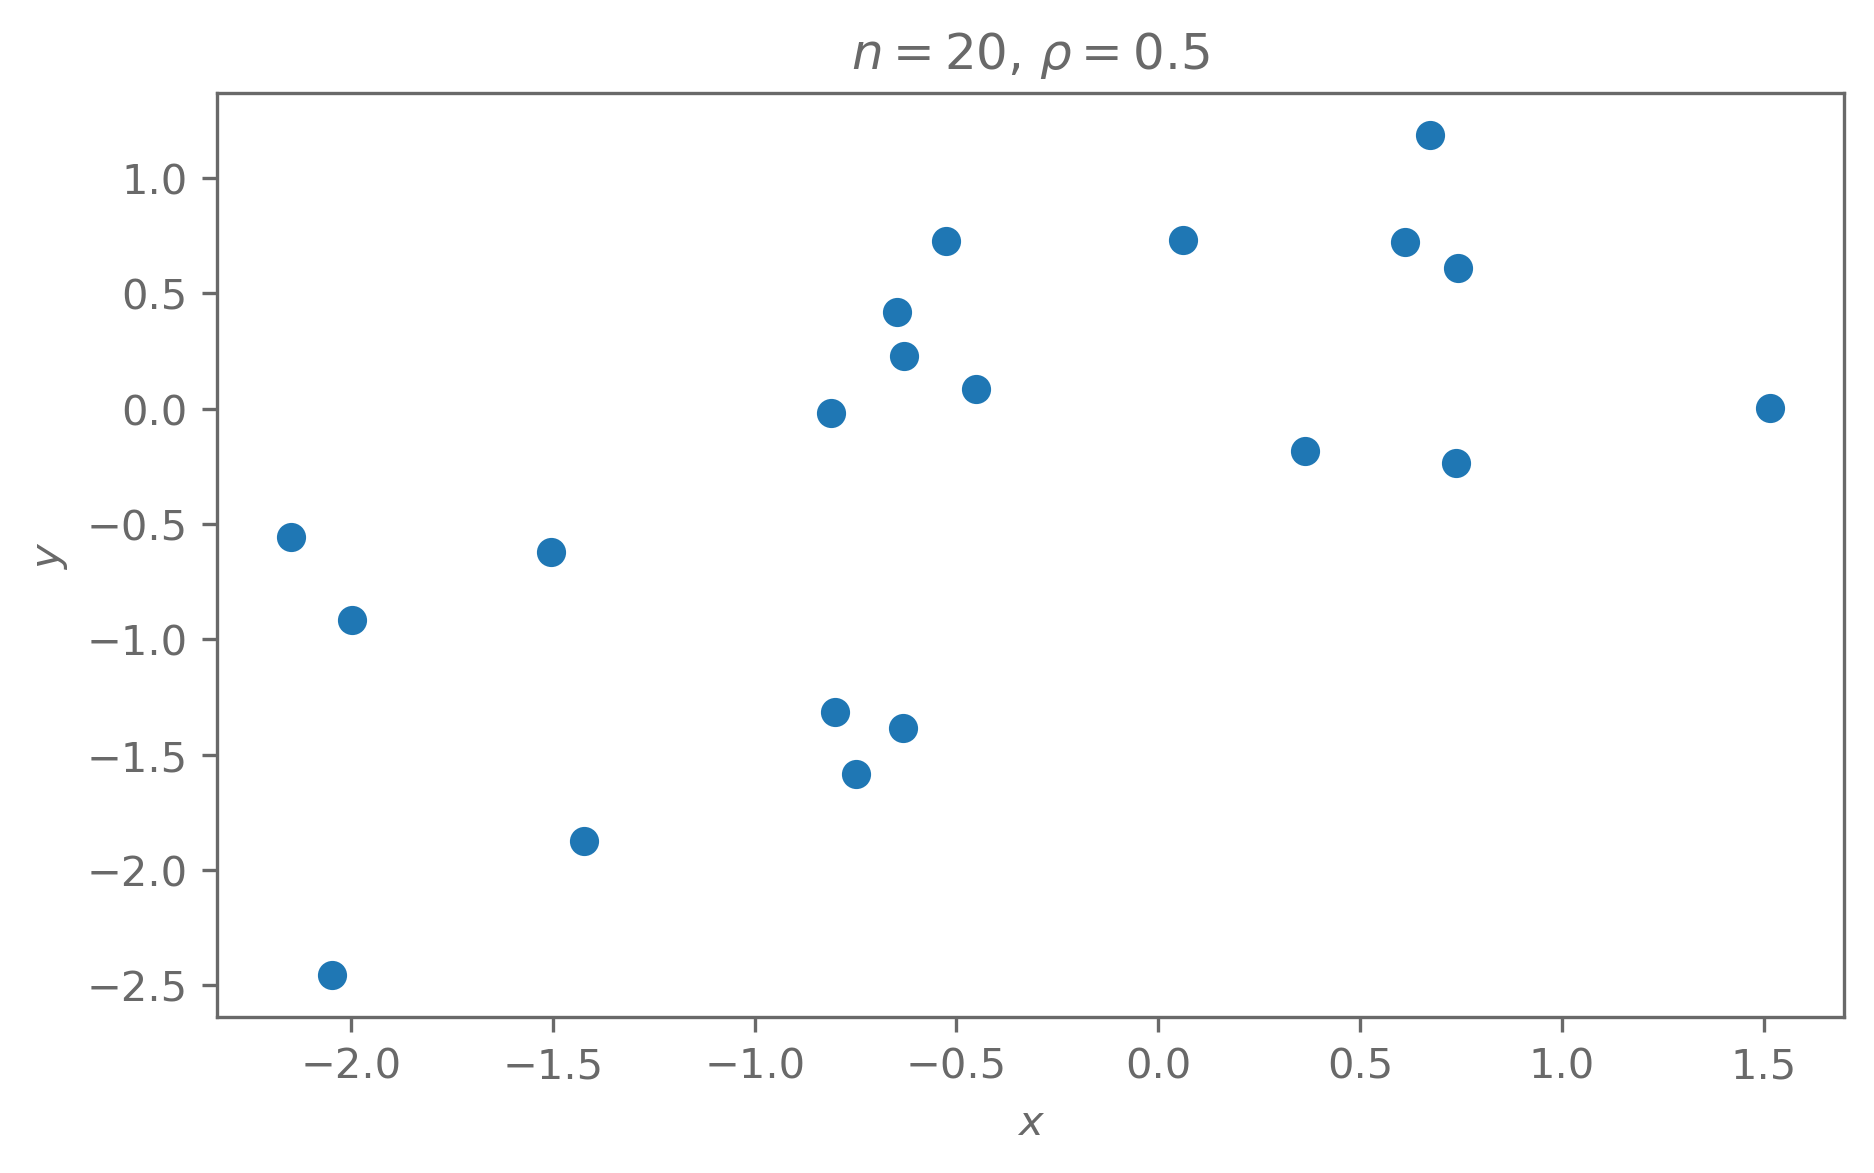

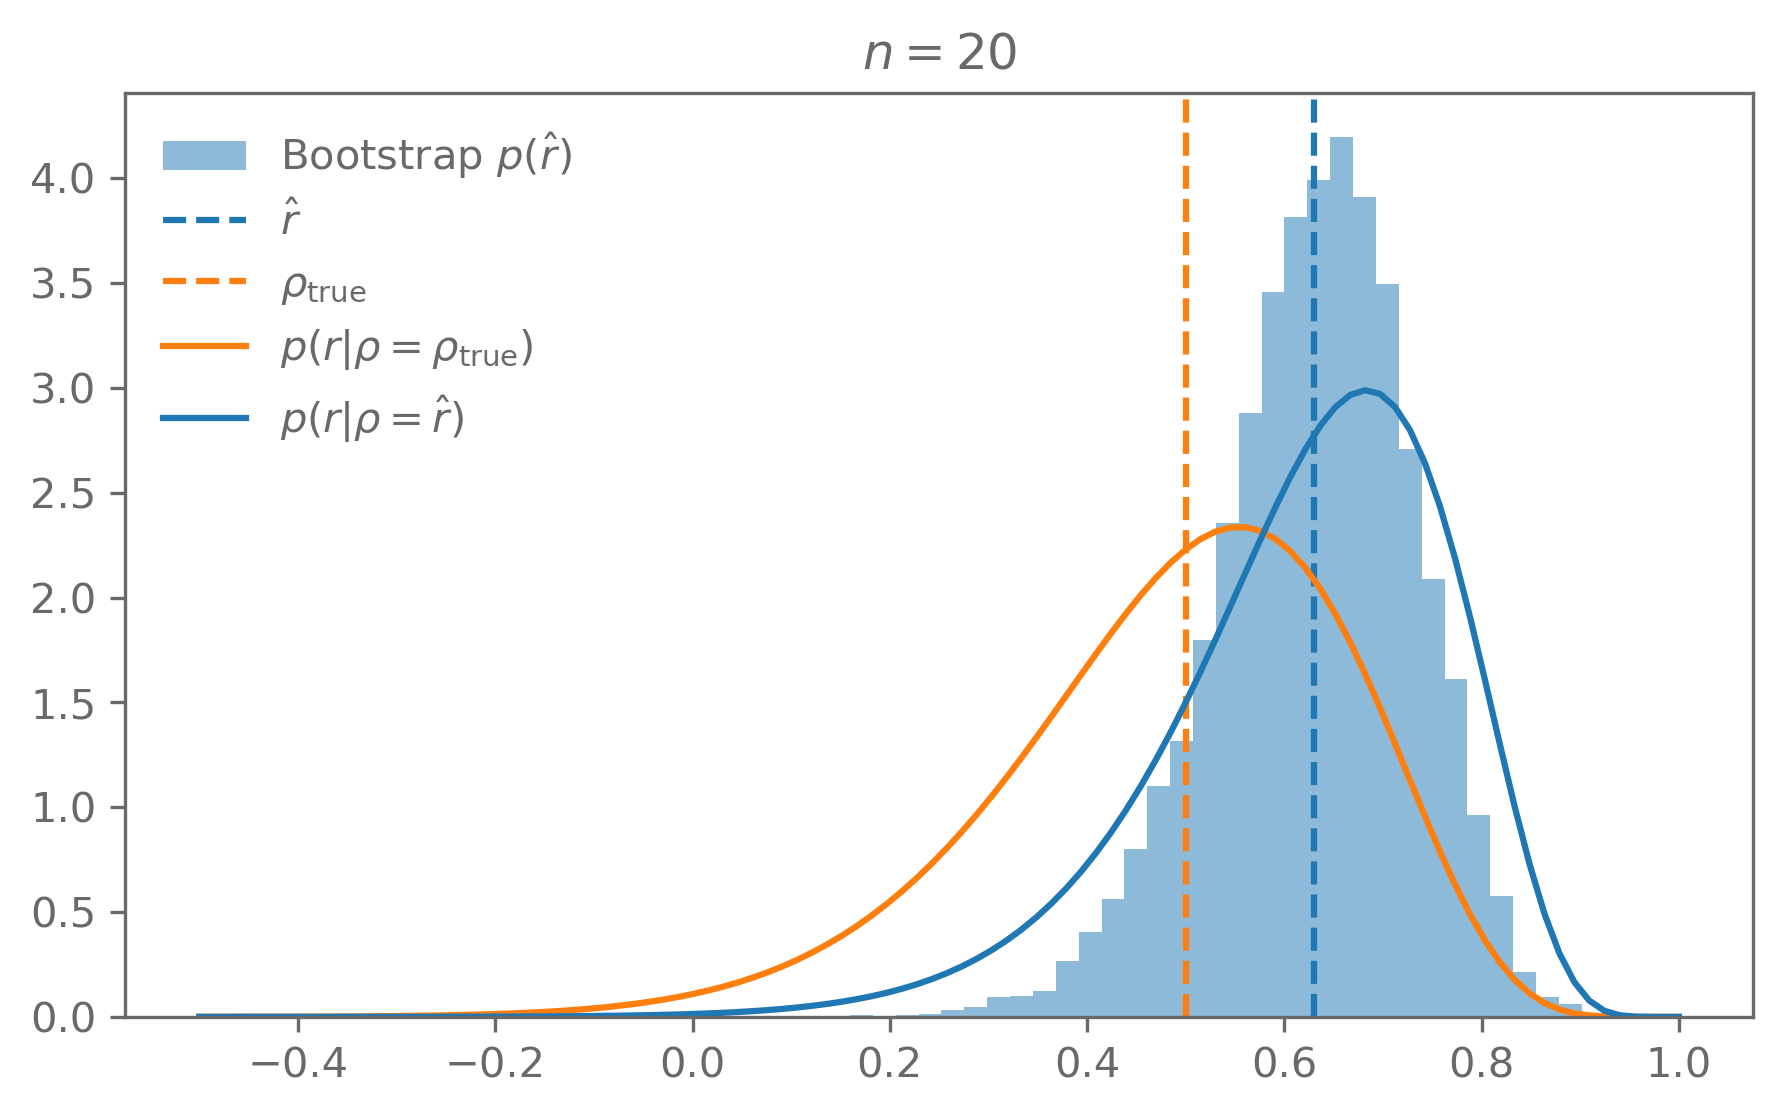

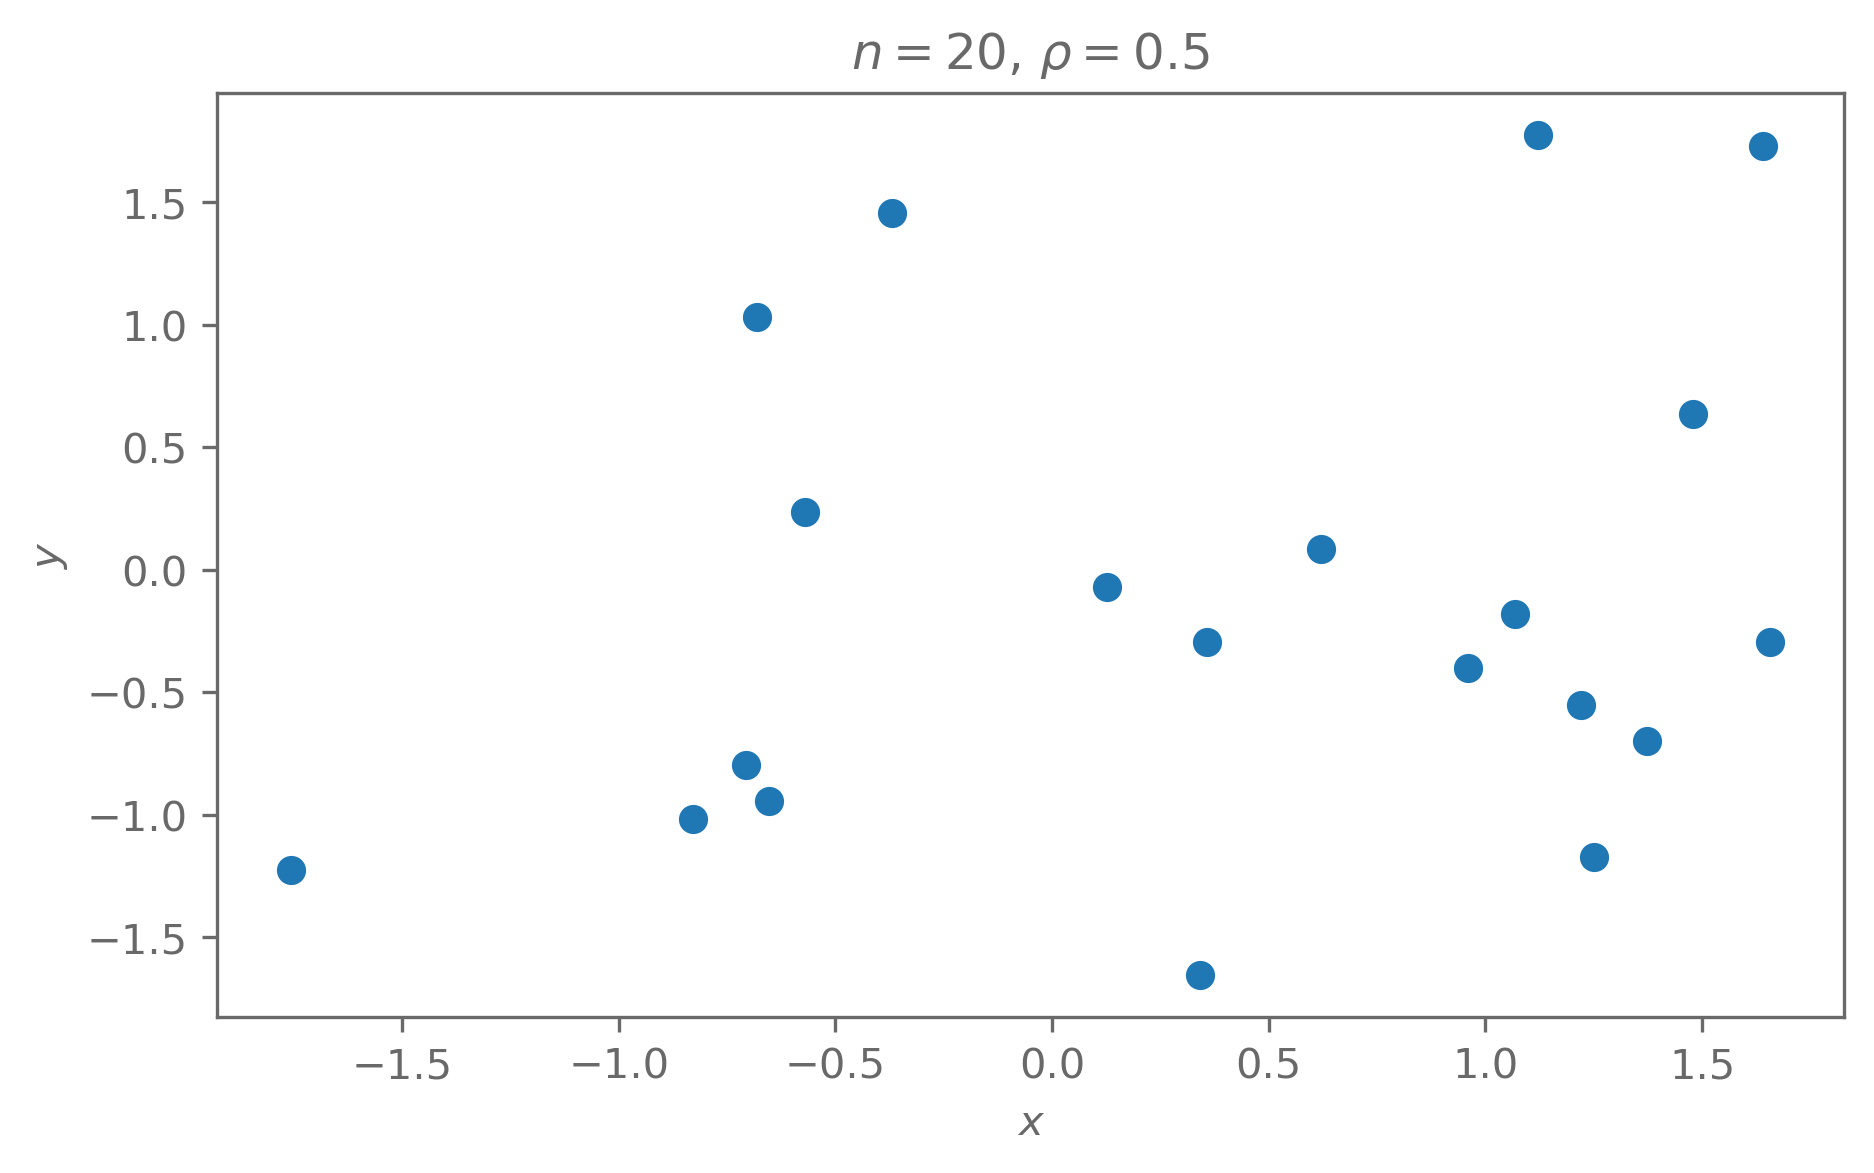

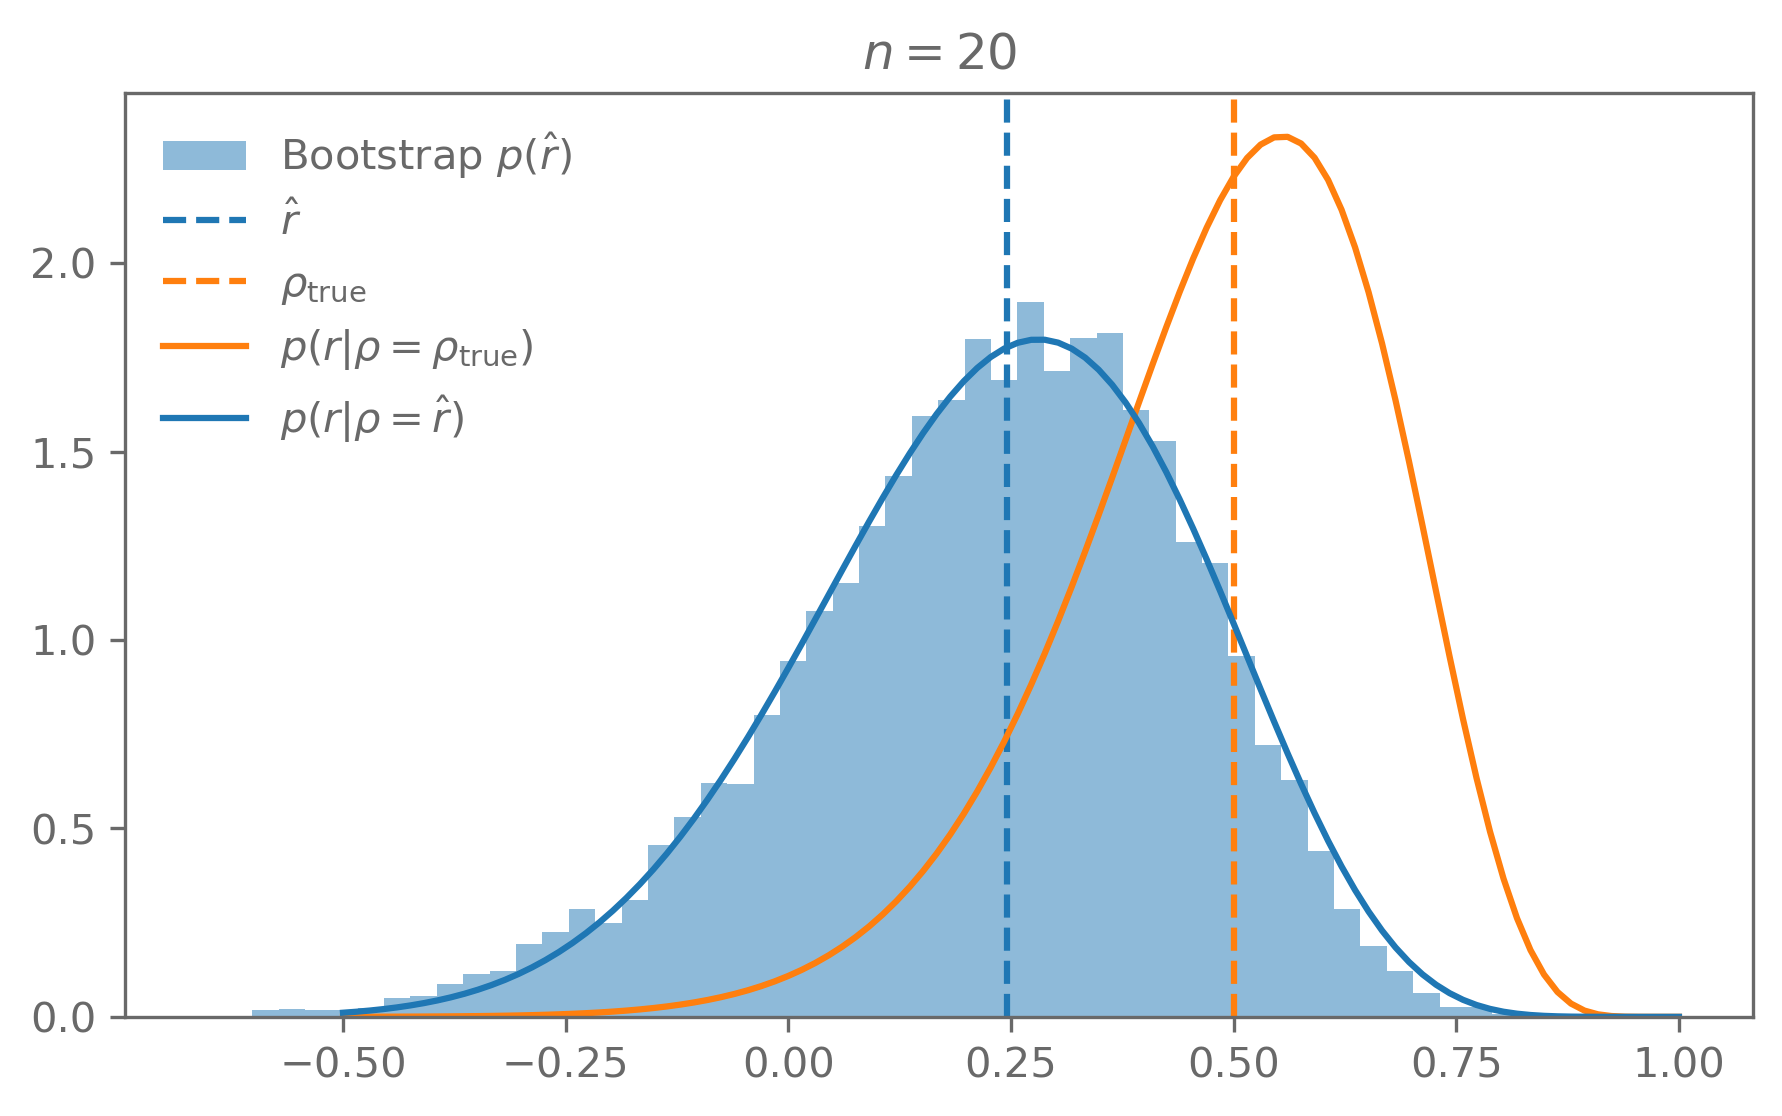

In [79]:
for _ in range(3):
    make_data_and_plots(n=20)

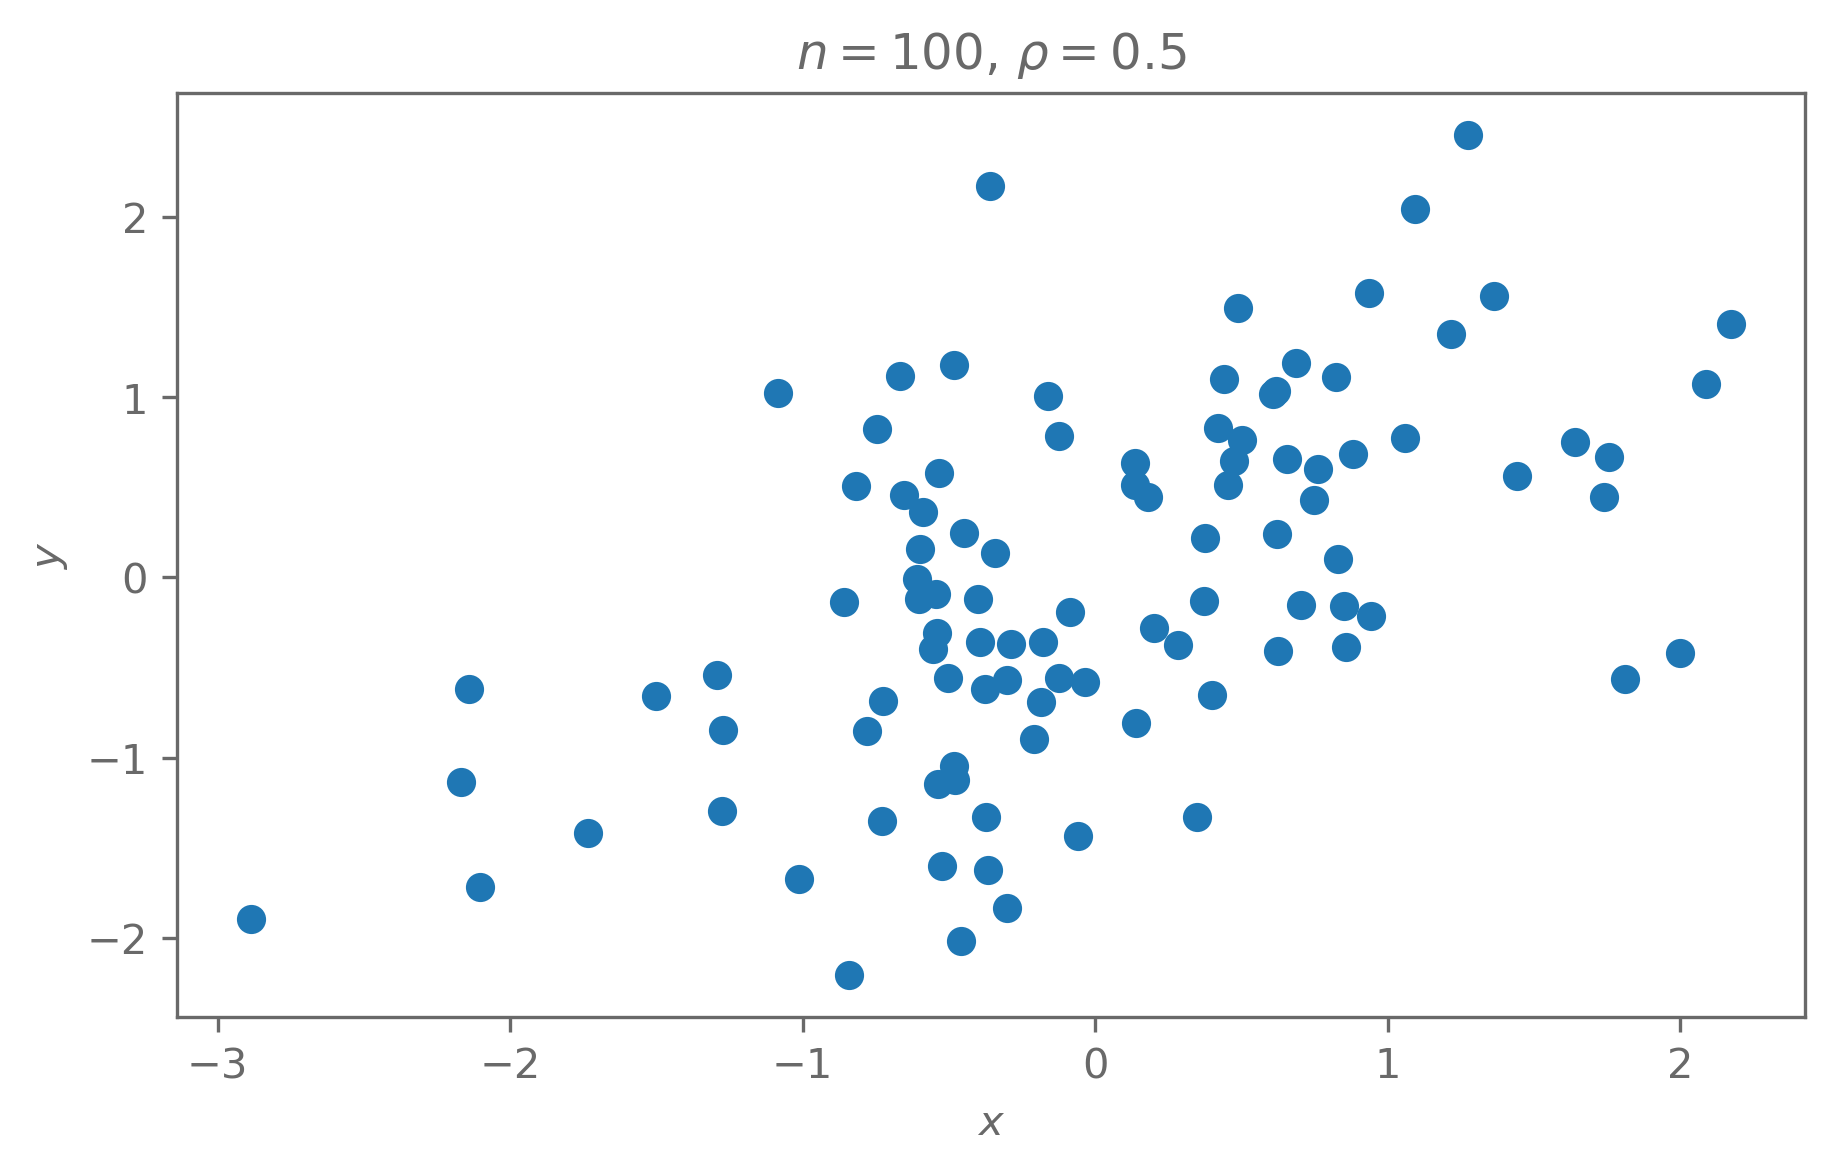

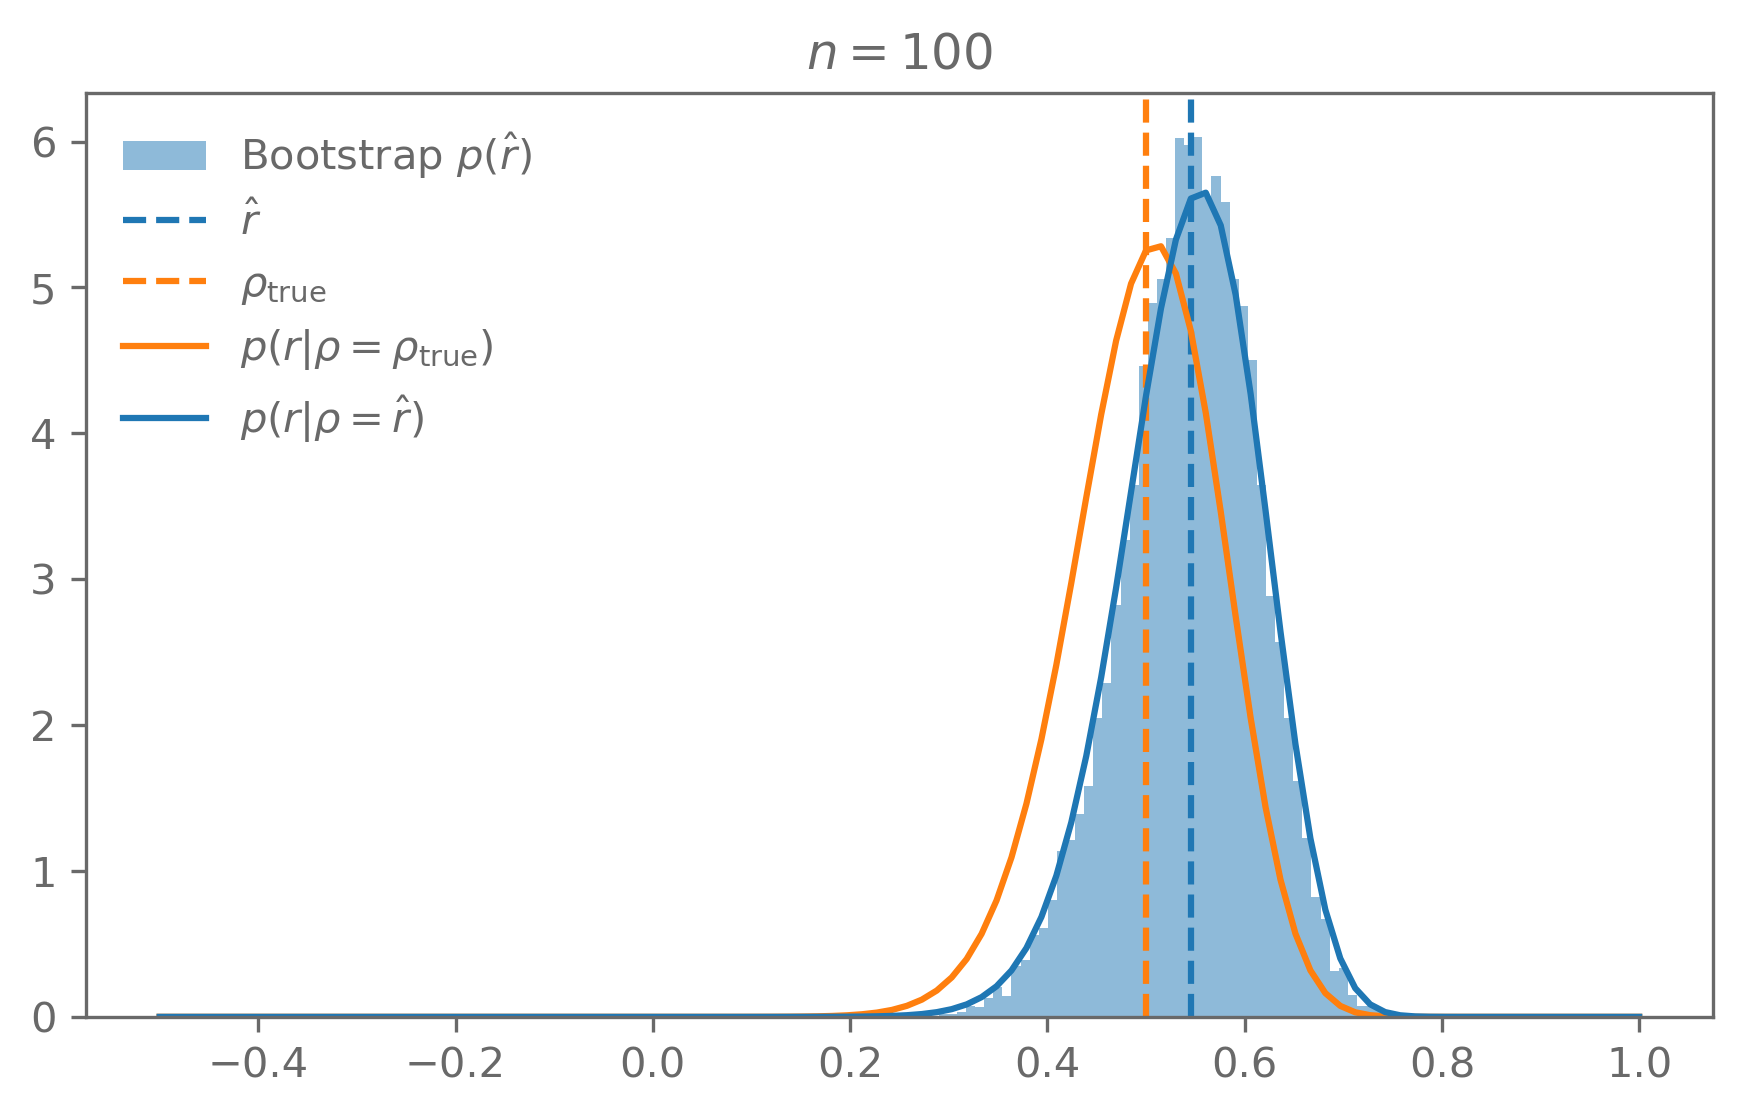

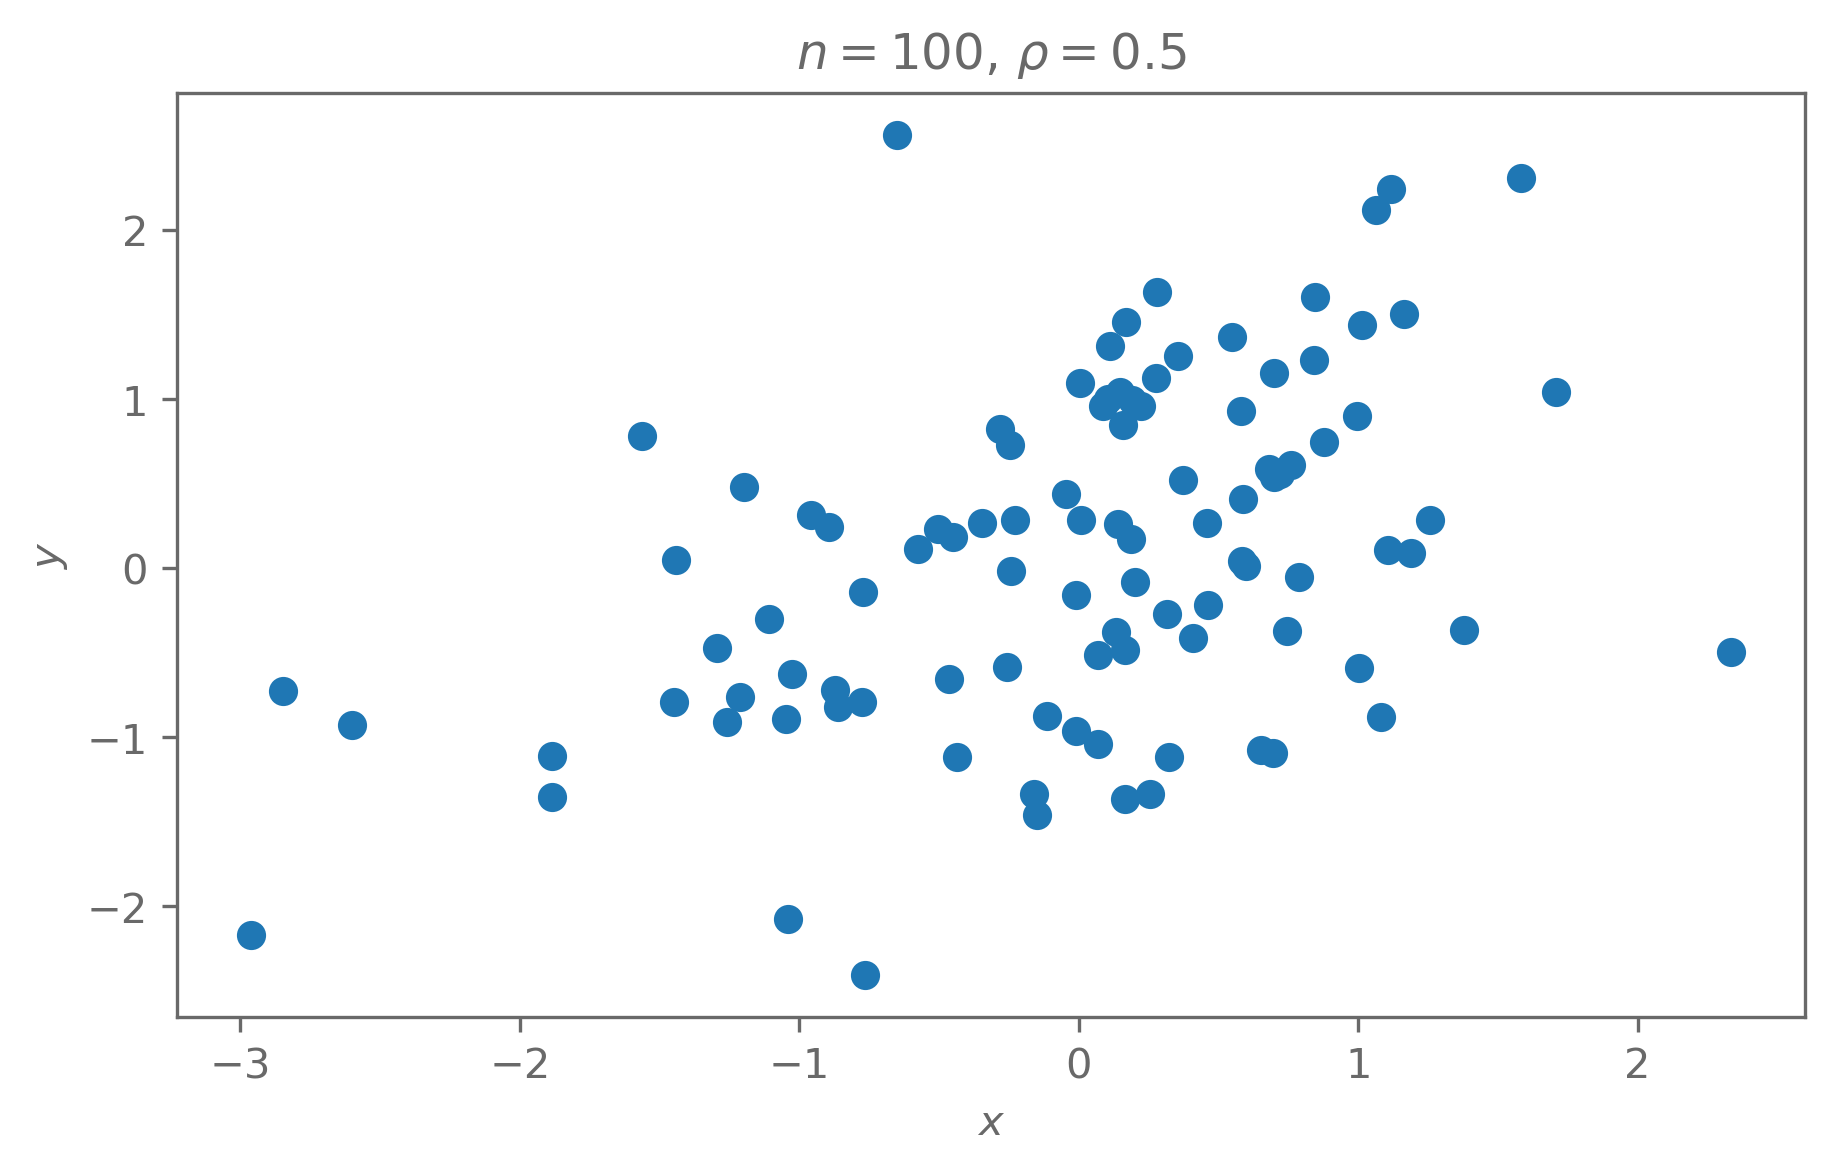

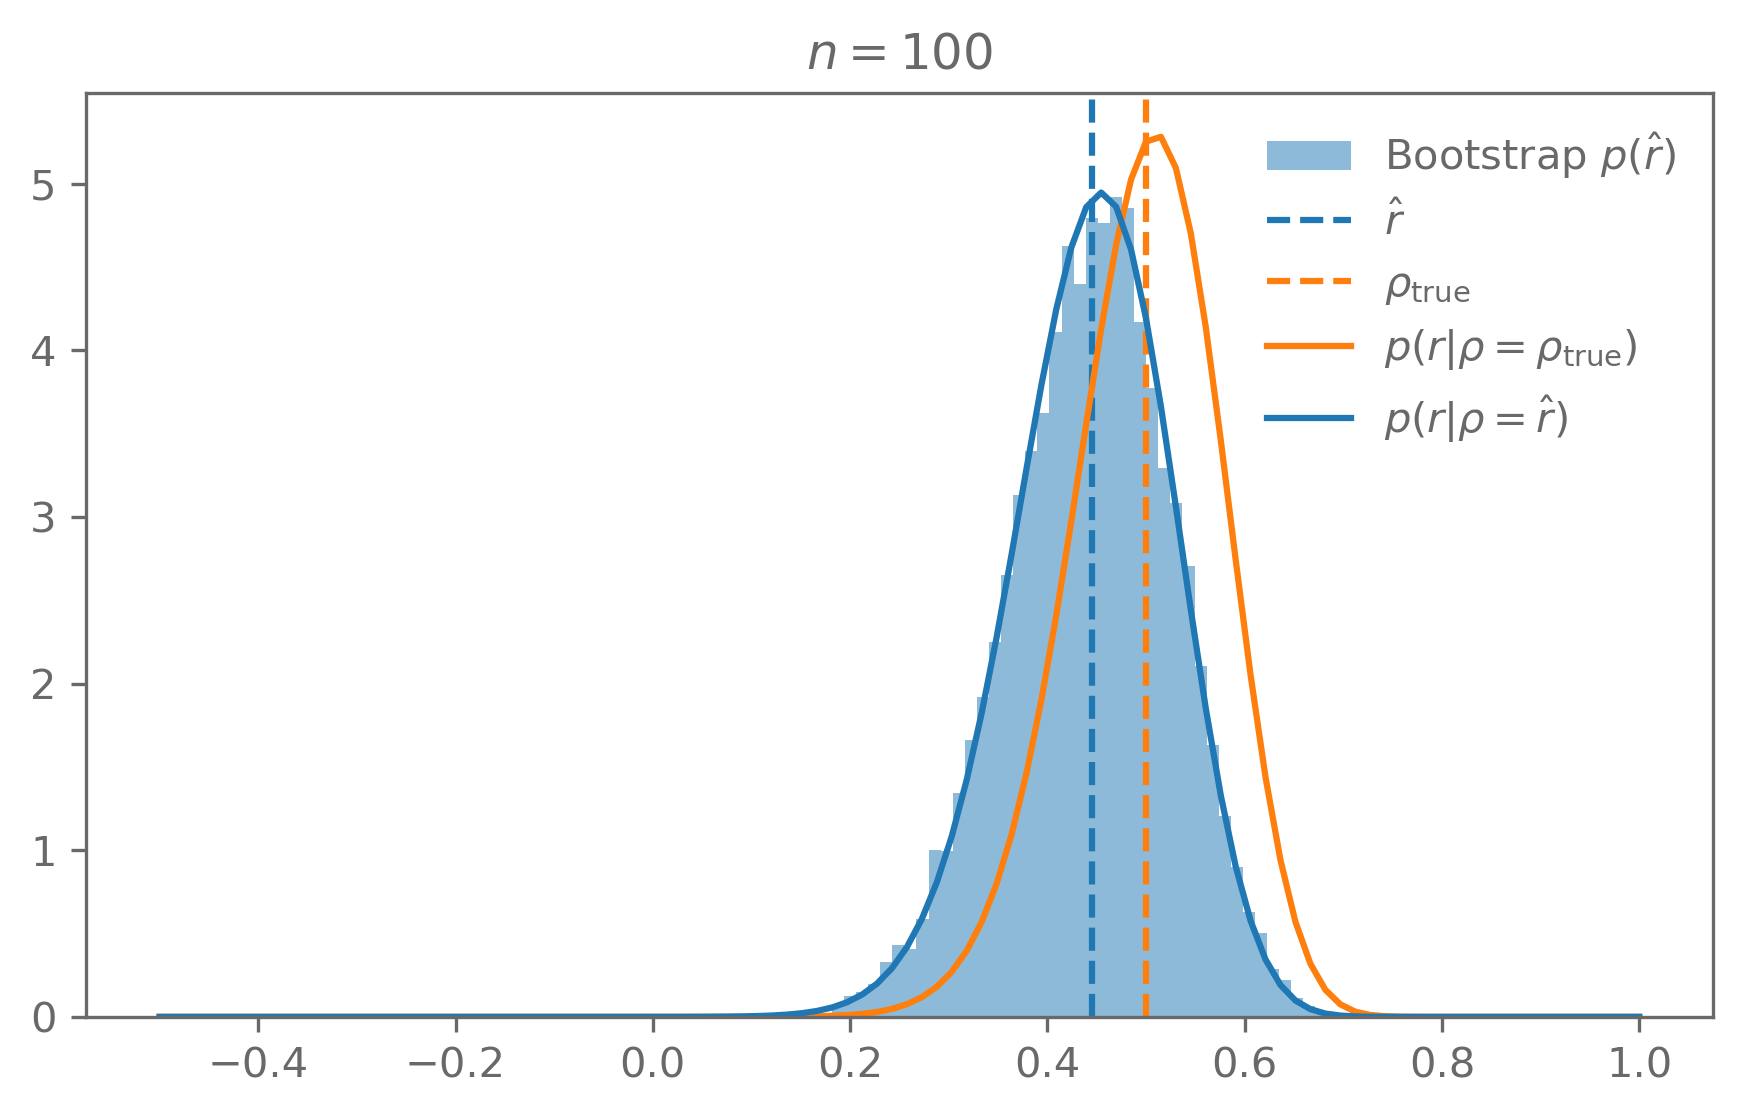

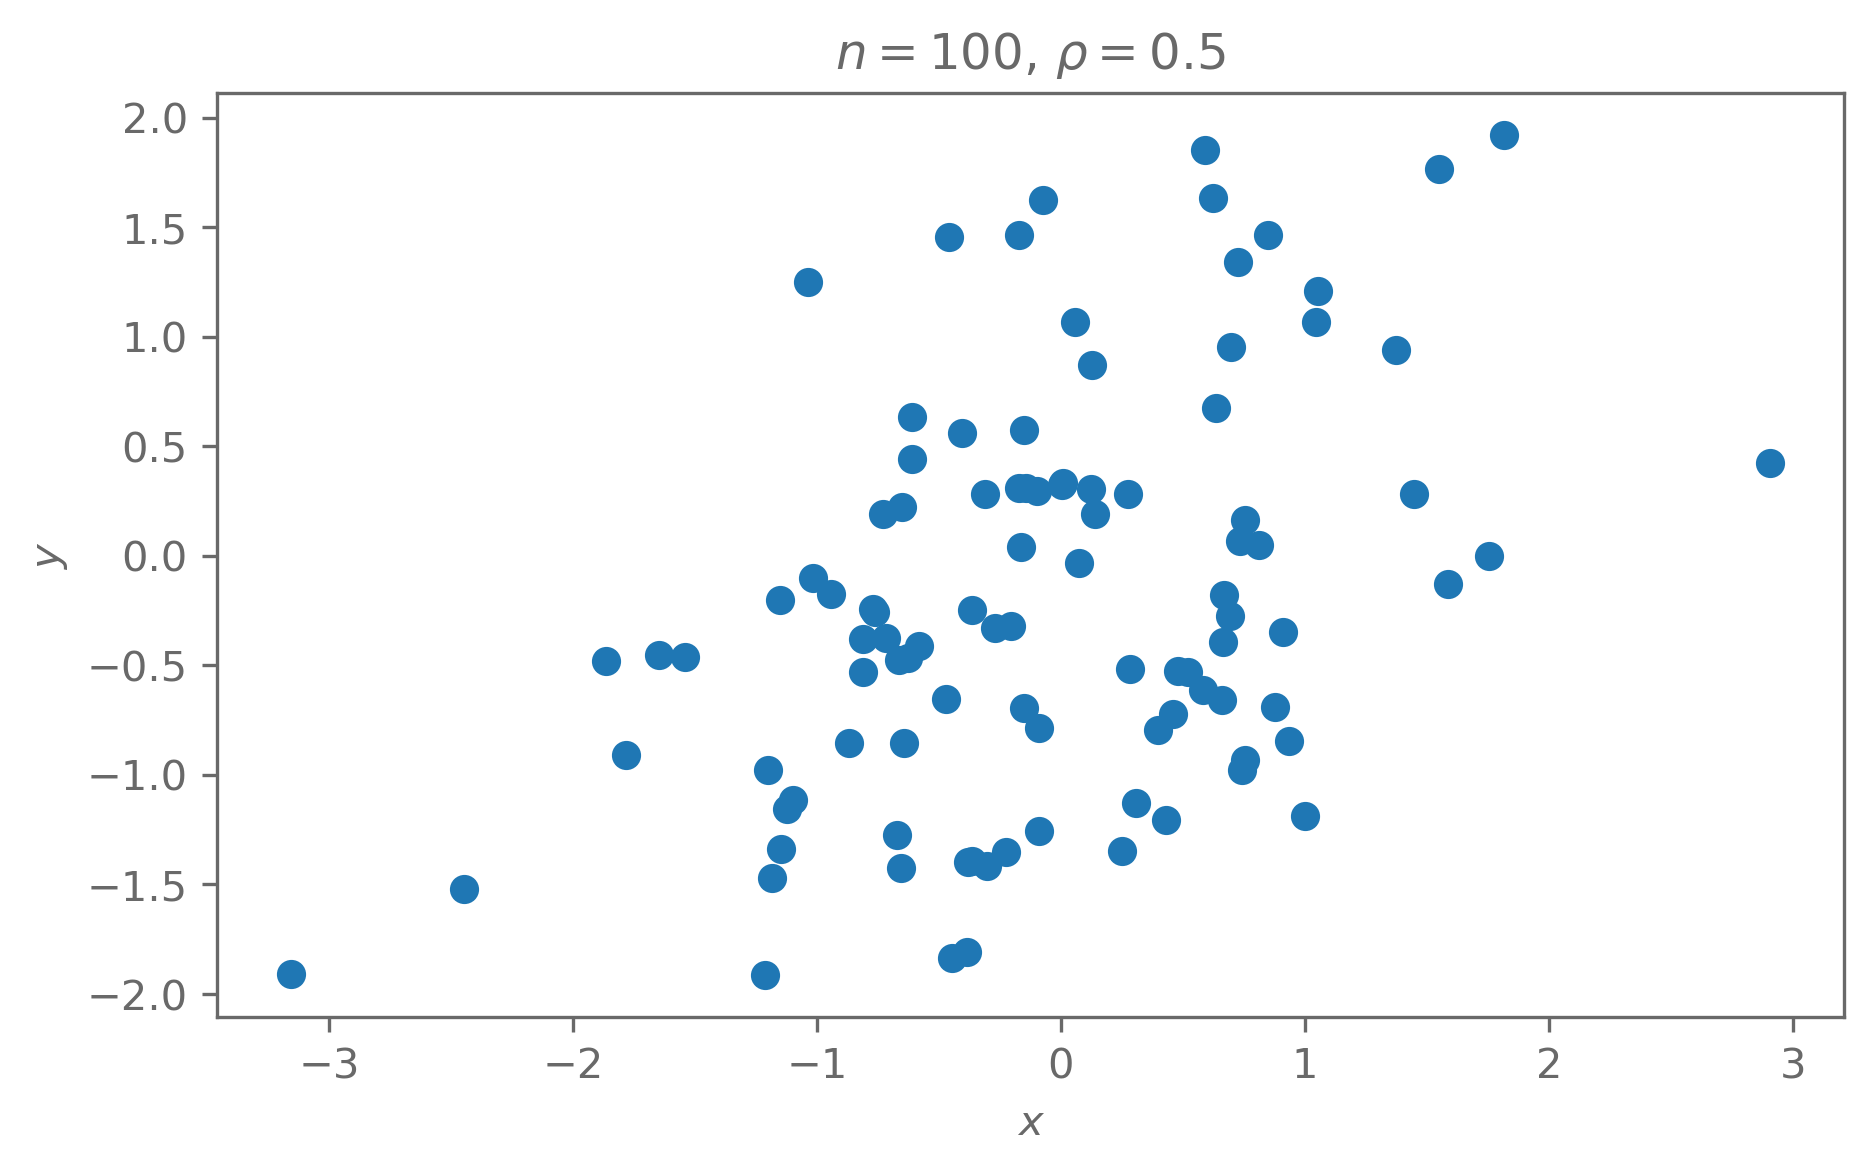

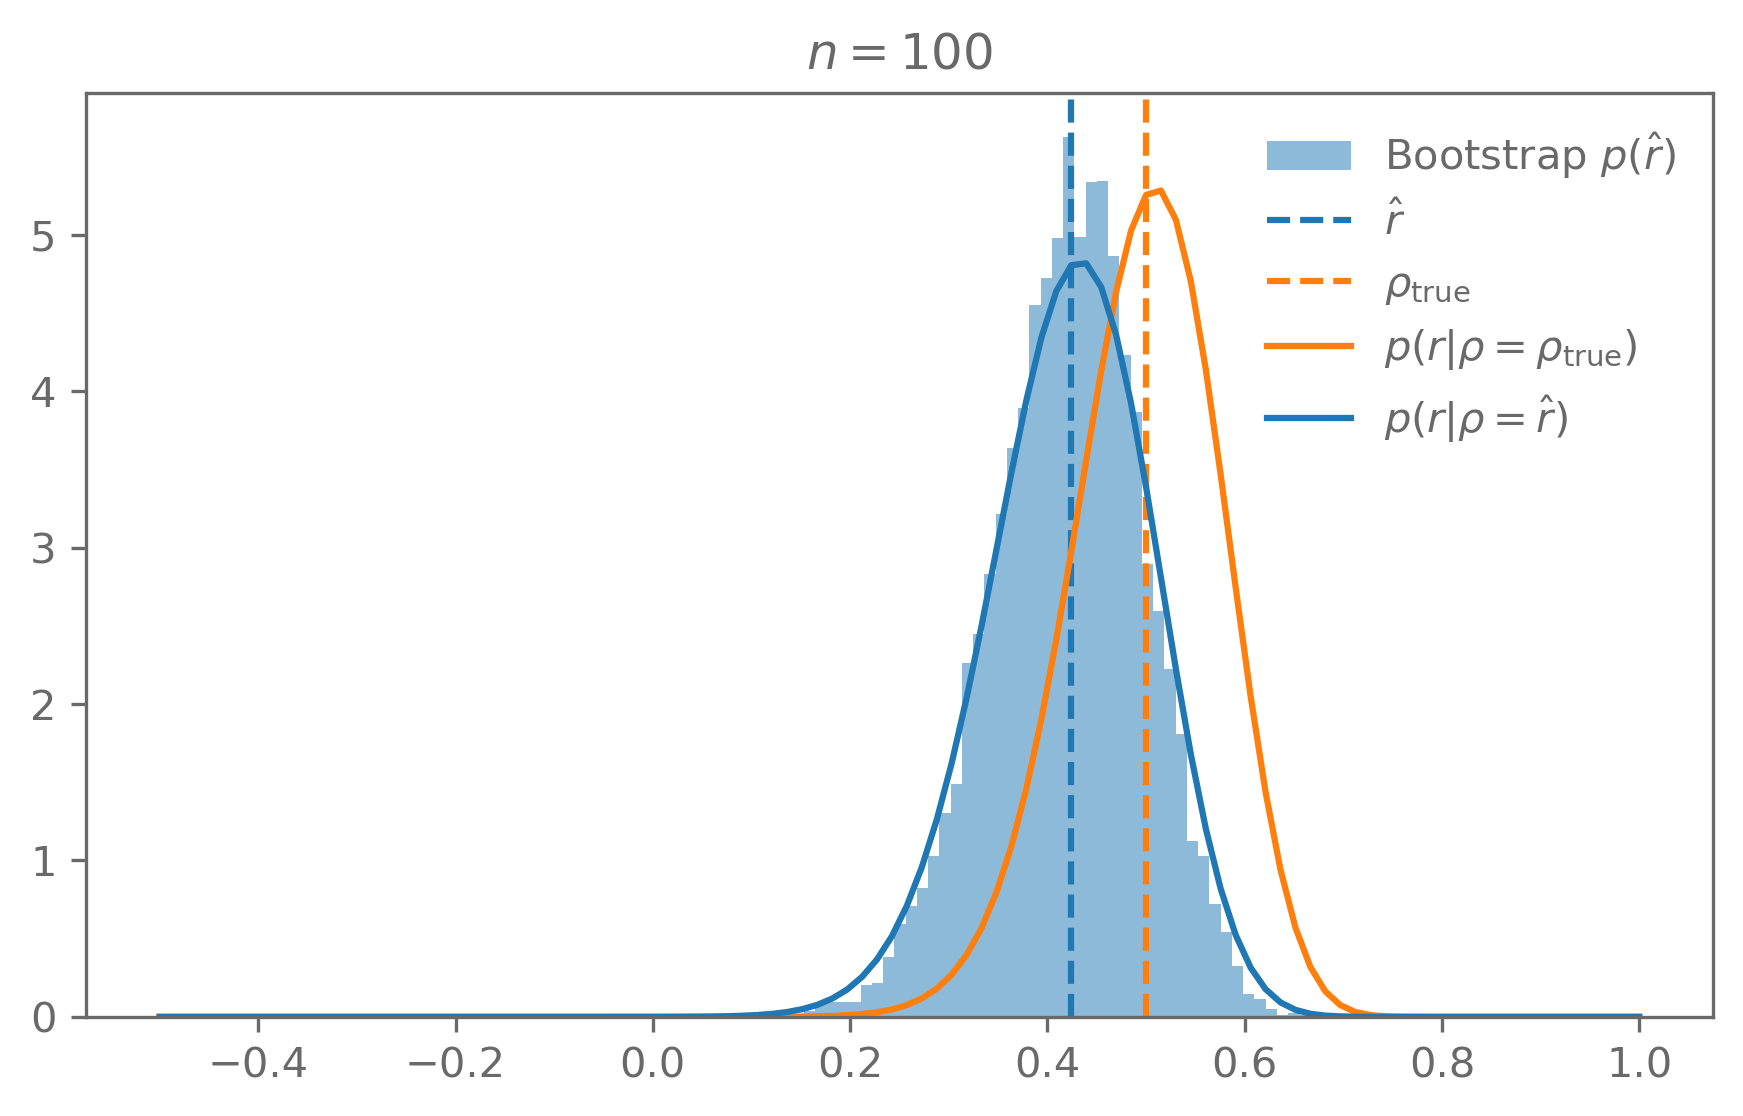

In [80]:
for _ in range(3):
    make_data_and_plots(n=100)
